In [2]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Sklearn
# ==============================================================================
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# MLflow
# ==============================================================================
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

# TensorFlow
# ==============================================================================
import tensorflow as tf
print(tf.__version__)
import joblib

2.15.0


# Load Data

In [ ]:
#!wget https://github.com/isaacmenchaca97/hospital_wait_time_prediction/releases/download/v1.0.0/ARTICLE.tar.gz
# !wget https://github.com/isaacmenchaca97/hospital_wait_time_prediction/releases/download/v1.0.0/EDIESCA.tar.gz

#!tar -xzvf ARTICLE.tar.gz
# !tar -xzvf EDIESCA.tar.gz

In [3]:
# Select target and features
df_regression = pd.read_csv('../data/processed/EDIESCA.csv')
X = df_regression.drop(columns=['tiempo_total'])
y = df_regression['tiempo_total']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
# Check if TPU is available
try:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # No need to specify TPU address if on Colab
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.TPUStrategy(resolver)
  print("Running on TPU")
  print("All devices: ", tf.config.list_logical_devices('TPU'))
except ValueError: # If TPU is not found, use default strategy
  strategy = tf.distribute.get_strategy()
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    print("Running on CPU")
  else:
    print("Running on GPU")


Running on CPU


# Regression Model

##### Linear Regression

In [5]:
with strategy.scope():
  modelo = LinearRegression()
  modelo.fit(X_train, y_train)

# Prediction
y_pred = modelo.predict(X_test)

# Obtener los coeficientes de cada variable explicativa
print("Coeficientes:", modelo.coef_)
print("Intercepto:", modelo.intercept_)

# Calcular el score R² (para ver el ajuste del modelo)
print("R²:", modelo.score(X, y))


Coeficientes: [ 8.20861573e+00  3.09805518e+00  2.08476062e+01  1.18088481e+01
  6.21724894e-15 -2.22044605e-15  6.66133815e-15  2.99760217e-15
 -5.55111512e-15  5.41233725e-16  6.43929354e-15  2.22044605e-15
  8.21565038e-15]
Intercepto: 48.68348040269314
R²: -1181.891190212175


/Users/isaacmenchacapanecatl/Documents/hospital_wait_time_prediction/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


##### K-NN Regression

In [ ]:
n_neighbors = 10
weights = 'distance'
with strategy.scope():
# with tf.device('/device:GPU:0'):
  model_knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights)
  model_knn.fit(X_train, y_train)

# Predictions
y_test_pred = model_knn.predict(X_test)

In [ ]:
# MLflow tracking
mlflow.set_experiment("Hospital_Wait_Time_Prediction")

with mlflow.start_run():
    # log parameters and metrics
    mlflow.log_param("n_neighbors", n_neighbors)
    mlflow.log_param("weights", weights)
    mlflow.log_metric("MAE", mean_absolute_error(y_test, y_test_pred))
    
    rows = np.random.choice(X_train.shape[0], size=50, replace=False)
    X_train_sample = X_train[rows, :]

    signature = infer_signature(X_train_sample, model_knn.predict(X_train_sample))
    
    # Log the trained model
    model_info = mlflow.sklearn.log_model(
        sk_model=model_knn,
        artifact_path="knn_regression",
        signature=signature,
        input_example=X_train_sample
        )

/Users/isaacmenchacapanecatl/Documents/hospital_wait_time_prediction/.venv/lib/python3.9/site-packages/mlflow/store/artifact/utils/models.py:31: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


Root Mean Squared Error (RMSE): 24.221278075636153
Mean Squared Error (MSE): 586.6703116172926
Coeficiente de determinación (R^2): -0.038749327457649585
Mean Absolute Error (MAE): 19.23577538299884
        Actual  Predicted
41531     50.0  48.429151
159338    48.0  50.856373
176509    38.0  38.924447
76017     87.0  52.007410
149067    72.0  48.907357
131905    74.0  40.657518
148674    62.0  53.851504
24385     62.0  43.100288
58555     35.0  53.129772
126597    28.0  36.231372


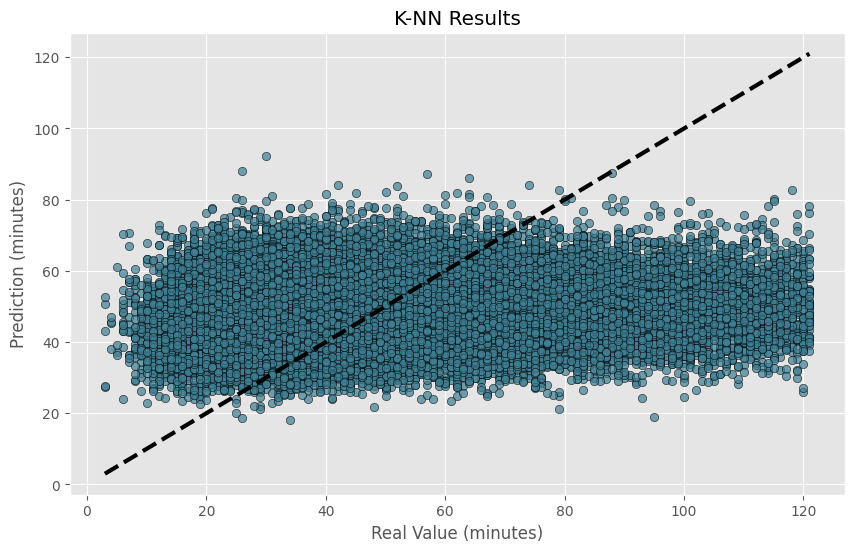

In [ ]:
# load best model
model_name = "model_knn"
model_version = "latest"
model_knn = mlflow.sklearn.load_model(f"models:/{model_name}/{model_version}")
y_test_pred = model_knn.predict(X_test)

# Métricas de evaluación
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, y_test_pred))}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_test_pred)}")
print(f"Coeficiente de determinación (R^2): {r2_score(y_test, y_test_pred)}")
print(f'Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_test_pred)}')

# Mostrar algunas predicciones junto con los valores reales
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred.flatten()})
print(predictions.head(10))

# Gráfico de dispersión de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, edgecolor='k', alpha=0.7, color="#3f7f93")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Real Value (minutes)')
plt.ylabel('Prediction (minutes)')
plt.title('K-NN Results')
plt.show()

##### DT Regression

In [ ]:
with strategy.scope():
# with tf.device('/device:GPU:0'):
  model_dt = DecisionTreeRegressor(max_depth=60, min_samples_leaf=4, min_samples_split=2)
  model_dt.fit(X_train, y_train)

# store model
joblib.dump(model_dt, 'model_dt.pkl')

Root Mean Squared Error (RMSE): 1.9934609501698601
Mean Squared Error (MSE): 3.973886559852122
Coeficiente de determinación (R^2): 0.9929724819328842
Mean Absolute Error (MAE): 1.2950014716361495
        Actual   Predicted
24760     51.0   51.250000
1116      22.0   21.666667
41101     36.0   37.200000
2695      21.0   21.000000
200880   115.0  102.250000
94999     54.0   53.750000
94676     55.0   54.750000
108258    67.0   65.200000
3786      27.0   27.000000
47492     38.0   37.750000


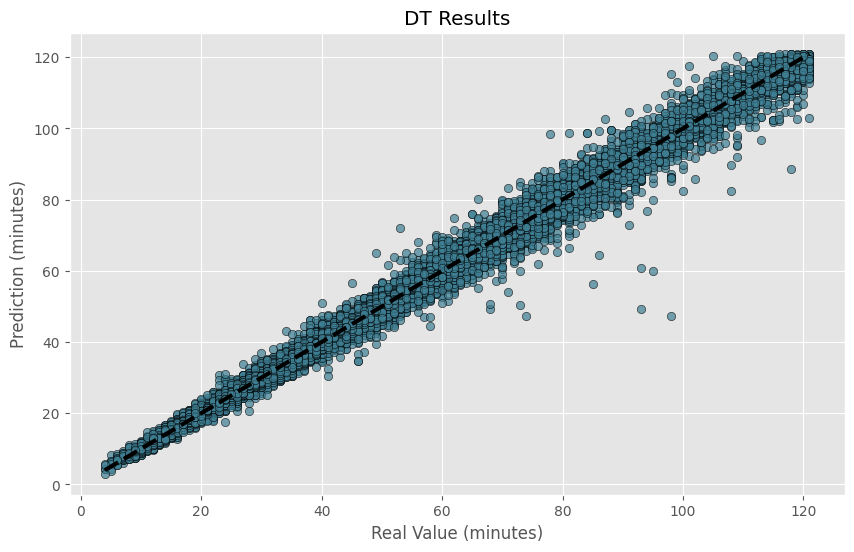

In [ ]:
# load model
model_dt = joblib.load('model_dt.pkl')

# Predictions
y_test_pred = model_dt.predict(X_test)

# Métricas de evaluación
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, y_test_pred))}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_test_pred)}")
print(f"Coeficiente de determinación (R^2): {r2_score(y_test, y_test_pred)}")
print(f'Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_test_pred)}')

# Mostrar algunas predicciones junto con los valores reales
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred.flatten()})
print(predictions.head(10))

# Gráfico de dispersión de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, edgecolor='k', alpha=0.7, color="#3f7f93")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Real Value (minutes)')
plt.ylabel('Prediction (minutes)')
plt.title('DT Results')
plt.show()